In [127]:
import sys
from pathlib import Path

project_root = Path().resolve().parent 
sys.path.append(str(project_root))

project_root

WindowsPath('D:/Workspace/Repository/ml-research-lab/spiral-drawing-digital-engine')

In [128]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC
import matplotlib.pyplot as plt
import seaborn as sns
from vit_pytorch.vit_for_small_dataset import ViT

torch.set_float32_matmul_precision('medium')

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [130]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image

# Load Dataset

In [131]:
data_dir = Path(project_root) / "data" / "kmader"
train_dir = data_dir / "training"
test_dir = data_dir / "testing"

# DataLoader

In [132]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(data_dir, cls_name)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(cls_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[cls_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

class SpiralDataModule(L.LightningDataModule):
    def __init__(self, train_dir, test_dir, batch_size=32, image_size=256):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.image_size = image_size
        
    def setup(self, stage=None):
        # Define transforms
        self.train_transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Create datasets
        self.train_dataset = ImageDataset(self.train_dir, transform=self.train_transform)
        self.val_dataset = ImageDataset(self.test_dir, transform=self.test_transform)
        self.test_dataset = ImageDataset(self.test_dir, transform=self.test_transform)
        
        # Store number of classes for model initialization
        self.num_classes = len(self.train_dataset.classes)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=0)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=0)

# Model 

In [133]:
class ViTLightningModule(L.LightningModule):
    def __init__(self, image_size=256, patch_size=16, num_classes=2, 
                 dim=1024, depth=6, heads=16, mlp_dim=2048,
                 dropout=0.1, emb_dropout=0.1, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        
        # Initialize ViT model
        self.model = ViT(
            image_size=image_size,
            patch_size=patch_size,
            num_classes=num_classes,
            dim=dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            emb_dropout=emb_dropout
        )
        
        # Define metrics
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits.softmax(dim=-1), y)
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits.softmax(dim=-1), y)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.test_acc(logits.softmax(dim=-1), y)
        
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.trainer.estimated_stepping_batches
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step"
            }
        }

# Training

In [134]:
data_module = SpiralDataModule(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=16,
    image_size=256
)

In [135]:
data_module.setup()

In [136]:
model = ViTLightningModule(
    image_size=256,
    patch_size=16,  
    num_classes=data_module.num_classes,
    dim=512,      
    depth=4,      
    heads=8,      
    mlp_dim=1024,  
    dropout=0.2,   
    emb_dropout=0.1,
    learning_rate=5e-5 
)

In [137]:
checkpoint_callback = ModelCheckpoint(
    dirpath=str(project_root / "logs" / "vit_checkpoints"),
    filename="vit-{epoch:02d}-{val_acc:.4f}",
    monitor="val_acc",
    mode="max",
    save_top_k=3
)

In [138]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=True,
    mode="min"
)

In [139]:
lr_monitor = LearningRateMonitor(logging_interval='step')

In [ ]:
logger = CSVLogger(save_dir=str(project_root / "logs" / "vit_logs"))

In [141]:
trainer = L.Trainer(
    max_epochs=100,
    accelerator="auto", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [142]:
trainer.fit(model, data_module)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ViT                | 10.5 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
42.054    Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.705


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.696


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.689


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.687


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.684


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.683


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.682


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.679


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.674


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.672


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.668


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.664


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.663


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.658


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.646


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.638


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.633


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.633. Signaling Trainer to stop.


In [143]:
def analyze_predictions(model, dataloader, num_batches=1):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            if i >= num_batches:
                break
            x = x.to(model.device)
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            
            print(f"Batch {i}:")
            print(f"Logits: {logits}")
            print(f"Probabilities: {probs}")
            print(f"Predictions: {preds}")
            print(f"True labels: {y}")
    
    print("\nOverall distribution:")
    print(f"Predictions distribution: {np.bincount(all_preds)}")
    print(f"True labels distribution: {np.bincount(all_labels)}")
    
    return all_preds, all_labels

# Use it
test_dataloader = data_module.test_dataloader()
analyze_predictions(model, test_dataloader, num_batches=2)

Batch 0:
Logits: tensor([[-0.9355,  0.7030],
        [-0.4687,  0.2168],
        [ 0.3630, -0.8216],
        [-0.4179,  0.0685],
        [-0.0159, -0.3681],
        [ 0.3743, -0.7633],
        [ 0.9452, -1.2630],
        [ 0.1777, -0.3833],
        [-0.0637, -0.2571],
        [ 0.8661, -1.1843],
        [-0.3120, -0.1178],
        [ 0.6178, -0.8929],
        [ 0.6095, -0.9161],
        [ 1.2776, -1.7300],
        [ 1.3155, -1.6583],
        [ 0.1130, -0.3526]])
Probabilities: tensor([[0.1627, 0.8373],
        [0.3350, 0.6650],
        [0.7658, 0.2342],
        [0.3807, 0.6193],
        [0.5871, 0.4129],
        [0.7572, 0.2428],
        [0.9010, 0.0990],
        [0.6367, 0.3633],
        [0.5482, 0.4518],
        [0.8860, 0.1140],
        [0.4516, 0.5484],
        [0.8192, 0.1808],
        [0.8214, 0.1786],
        [0.9529, 0.0471],
        [0.9514, 0.0486],
        [0.6143, 0.3857]])
Predictions: tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
True labels: tensor([0, 0, 0, 0,

([np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1)],
 [np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1)])

# Eval

In [144]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Workspace\Repository\ml-research-lab\.ml-research-lab-venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5333333611488342
        test_loss           0.7107800841331482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7107800841331482, 'test_acc': 0.5333333611488342}]

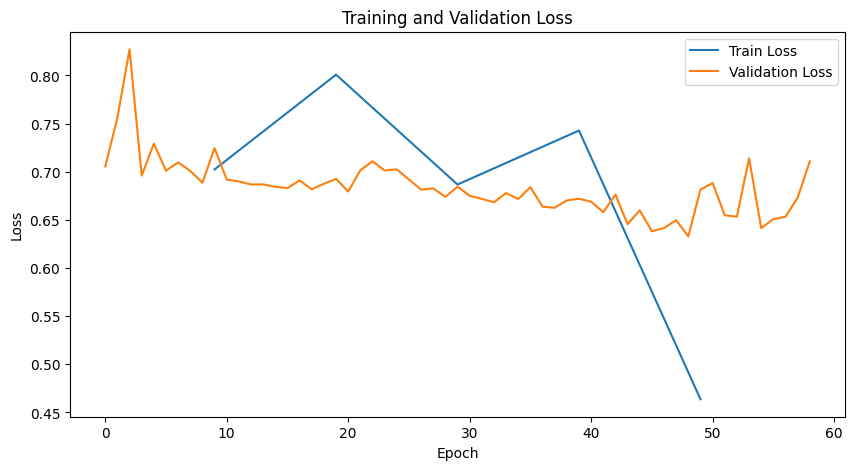

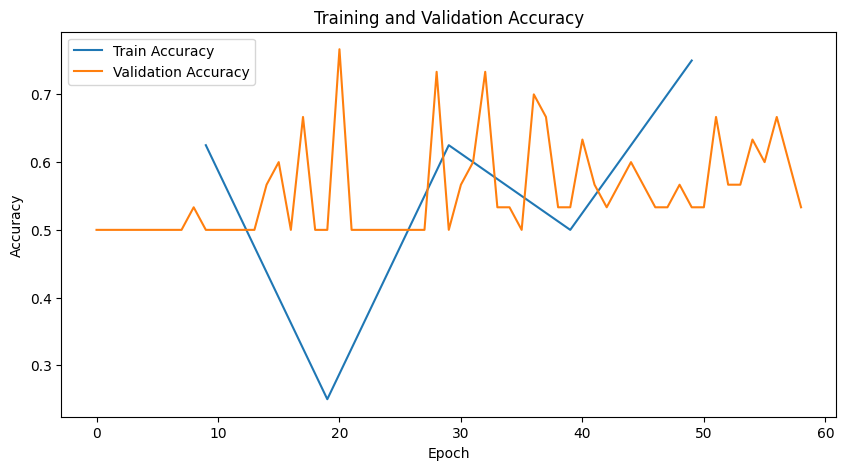

In [145]:
# Load training metrics
metrics = pd.read_csv(str(project_root / "logs" / "vit_logs" / "version_7" / "metrics.csv"))

# Plot training and validation loss
plt.figure(figsize=(10, 5))
train_loss = metrics[metrics['train_loss'].notna()][['epoch', 'train_loss']].groupby('epoch').mean()
val_loss = metrics[metrics['val_loss'].notna()][['epoch', 'val_loss']].groupby('epoch').mean()

plt.plot(train_loss.index, train_loss['train_loss'], label='Train Loss')
plt.plot(val_loss.index, val_loss['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')s
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
train_acc = metrics[metrics['train_acc'].notna()][['epoch', 'train_acc']].groupby('epoch').mean()
val_acc = metrics[metrics['val_acc'].notna()][['epoch', 'val_acc']].groupby('epoch').mean()

plt.plot(train_acc.index, train_acc['train_acc'], label='Train Accuracy')
plt.plot(val_acc.index, val_acc['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()